In [11]:
import pandas as pd
import numpy as np

import sys
import os

# Get the current working directory (where the notebook is running)
notebook_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now you can import your module
from utils import factor_model_solution, factor_goodness_of_fit_test

*This notebook does factor analysis on k = 2 pathways, trying to identify the 2 pathways in which DICER1 and GART participate in respectively.*
___
# $k = 2$ factors | GART & DICER1 pathways

## Loading and preparing data

See the `k1_[GENE]_initial_analysis.ipynb` notebooks for more intermediate steps than this notebook provides.

In [12]:
df_gene_effect = pd.read_csv("preprocessed_data/20Q4v2_Achilles_gene_effect.csv")
df_correlations = {
    "DICER1": pd.read_csv("preprocessed_data/corr_DICER1_preprocessed.csv", delimiter=";"),
    "GART": pd.read_csv("preprocessed_data/corr_GART_preprocessed.csv", delimiter=";")
}

In [13]:
# Number of genes to include from each corr file taking top X // 2 and bottom X // 2.
# Note that the same gene may be selected in both corr files. (But will only appear once in the final selected_genes list.)
number_of_genes = 10
assert number_of_genes % 2 == 0, "number_of_genes should be an even number."

selected_columns = pd.concat([df_correlations["DICER1"]["gene_evaluated"][:number_of_genes // 2],
                              df_correlations["GART"]["gene_evaluated"][:number_of_genes // 2]]).to_list()
selected_columns = set(selected_columns)

# number_of_genes multiplied by how many corr files we have.
number_of_duplicates = (number_of_genes * len(df_correlations)) - len(selected_columns) 
if number_of_duplicates > 0:
    print(f"Warning: {number_of_duplicates} duplicates were removed.")

# Extract gene names according to the format of gene_effect dataset.
selected_columns_gene_effect_format = [column for column in df_gene_effect.columns if column.split(" ")[0] in selected_columns]

# Rough automatic check for whether we found all corresponding columns in gene_effect dataset that we've selected.
assert len(selected_columns) == len(selected_columns_gene_effect_format)

# Extract columns from gene_effect dataset.
X = df_gene_effect[selected_columns_gene_effect_format].dropna() # Is dropping rows with na a good idea? Maybe use mean value instead?
X = X.to_numpy()
num_dropped_rows = df_gene_effect.shape[0] - X.shape[0]
if num_dropped_rows > 0:
    print(f"Warning: {num_dropped_rows} rows contained at least 1 NA and was dropped.")
X.shape

(808, 10)

In [ ]:
num_random_cols = 10

X_with_random_noise = np.hstack([X] + [np.random.random(size=X.shape[0]).reshape(-1, 1) for _ in range(num_random_cols)])

X_with_random_noise.shape

## Data Analysis

In [15]:
_, lambda_hat = factor_model_solution(X_with_random_noise, k = 2)
lambda_hat

array([[-1.06933254e-01, -4.82296829e-01],
       [-7.38672358e-02, -4.98351074e-01],
       [-8.78955452e-01,  2.97990486e-02],
       [-1.92900568e-02, -7.05372629e-01],
       [ 7.53123470e-04, -4.15125689e-01],
       [-8.77405165e-01,  3.47663605e-02],
       [-8.56764210e-01,  2.13592404e-03],
       [-9.02038768e-01, -7.74108963e-03],
       [-8.41518151e-01, -4.62550212e-04],
       [-5.91254143e-02, -6.88276156e-01],
       [-3.04771766e-04,  2.41899702e-02],
       [ 3.92916425e-02,  1.77157303e-03],
       [-4.82947385e-02, -1.92925571e-03],
       [ 4.59645138e-02, -1.68302142e-02],
       [ 1.57939013e-02, -1.15703570e-02],
       [-2.50274027e-02,  3.85573112e-02],
       [ 1.27518285e-02,  1.38951707e-02],
       [-1.45468115e-02,  2.04623383e-02],
       [-5.83680215e-02,  6.08243702e-02],
       [-1.44838538e-02, -1.72231046e-02]])

In [16]:
loadings = lambda_hat.T # Extract loadings as a list

# Extract gene names (everything before the space)
genes = [column.split(" ")[0] for column in selected_columns_gene_effect_format] 

genes = genes + [str(i) + " random col" for i in range(num_random_cols)]

# Create a DataFrame from genes and values
df_values = pd.DataFrame({
    'gene_evaluated': genes,
    'loadings0': loadings[0],
    'loadings1': loadings[1]
})

# Merge with df_correlations on 'gene'
merged_df = (df_values
             .merge(df_correlations["DICER1"][['gene_evaluated', 'is_on_pathway']], on='gene_evaluated', how='left')
             .rename(columns={"is_on_pathway": "is_on_pathway_DICER1"})
             .merge(df_correlations["GART"][['gene_evaluated', 'is_on_pathway']], on='gene_evaluated', how='left')
             .rename(columns={"is_on_pathway": "is_on_pathway_GART"})
             )

In [17]:
# Allow pandas to display wider tables before linebreaking.
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Sorted w.r.t. first factor:

In [18]:
print(merged_df.sort_values("loadings0", ascending=False))

   gene_evaluated  loadings0  loadings1  is_on_pathway_DICER1  is_on_pathway_GART
13   3 random col   0.045965  -0.016830                   NaN                 NaN
11   1 random col   0.039292   0.001772                   NaN                 NaN
14   4 random col   0.015794  -0.011570                   NaN                 NaN
16   6 random col   0.012752   0.013895                   NaN                 NaN
4          DROSHA   0.000753  -0.415126                   1.0                 0.0
10   0 random col  -0.000305   0.024190                   NaN                 NaN
19   9 random col  -0.014484  -0.017223                   NaN                 NaN
17   7 random col  -0.014547   0.020462                   NaN                 NaN
3          DICER1  -0.019290  -0.705373                   1.0                 0.0
15   5 random col  -0.025027   0.038557                   NaN                 NaN
12   2 random col  -0.048295  -0.001929                   NaN                 NaN
18   8 random co

Correctly finds the GART pathway. (Notice the steep drop-off in loading from PFAS to AGO2)

Sorted w.r.t. second factor:

In [19]:
print(merged_df.sort_values("loadings1", ascending=False))

   gene_evaluated  loadings0  loadings1  is_on_pathway_DICER1  is_on_pathway_GART
18   8 random col  -0.058368   0.060824                   NaN                 NaN
15   5 random col  -0.025027   0.038557                   NaN                 NaN
5            GART  -0.877405   0.034766                   NaN                 1.0
2            ATIC  -0.878955   0.029799                   NaN                 1.0
10   0 random col  -0.000305   0.024190                   NaN                 NaN
17   7 random col  -0.014547   0.020462                   NaN                 NaN
16   6 random col   0.012752   0.013895                   NaN                 NaN
6          MTHFD1  -0.856764   0.002136                   NaN                 1.0
11   1 random col   0.039292   0.001772                   NaN                 NaN
8            PFAS  -0.841518  -0.000463                   NaN                 1.0
12   2 random col  -0.048295  -0.001929                   NaN                 NaN
7           PAIC

Correctly finds the DICER1 pathway. (Notice somewhat significant drop-off from DROSHA to HYOU1)

## Goodness of Fit

In [20]:
print(factor_goodness_of_fit_test(X, k = 2))

for i in range(1, X.shape[1]):
    pvalue = factor_goodness_of_fit_test(X, k = i)
    if pvalue >= 0.05:
        print("Found sufficient factors:")
        print("FAC| PVAL")
        print(f" {i} | {pvalue.round(4)}")
        print(f"({i - 1} | {factor_goodness_of_fit_test(X, k = i - 1).round(4)})")
        break

3.4422929504764765e-09
Found sufficient factors:
FAC| PVAL
 5 | 0.685
(4 | 0.0104)


Text(0, 0.5, '2nd Factor')

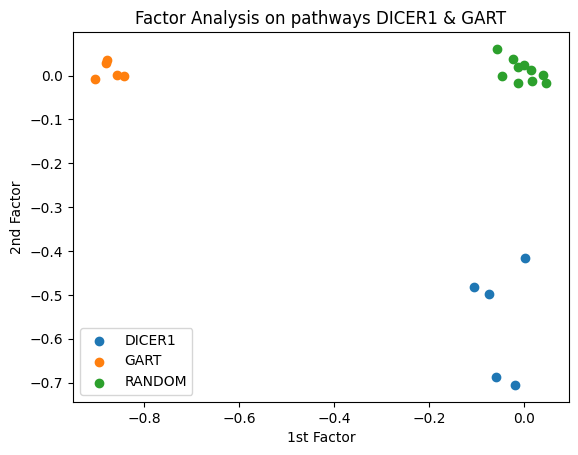

In [50]:
import matplotlib.pyplot as plt

colors = []
for d, g in zip(merged_df['is_on_pathway_DICER1'], merged_df['is_on_pathway_GART']):
    if d == 1:
        colors.append("DICER1")
        continue

    if g == 1:
        colors.append("GART")
        continue

    colors.append("RANDOM")

merged_df['category'] = colors

for label in ["DICER1", "GART", "RANDOM"]:
    subset = merged_df[merged_df['category'] == label]
    plt.scatter(subset['loadings0'], subset['loadings1'], label=label)
plt.title("Factor Analysis on pathways DICER1 & GART")
plt.legend()
plt.xlabel("1st Factor")
plt.ylabel("2nd Factor")